In [262]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd
import seaborn as sns

In [233]:
df = pd.read_csv('./AustinHousingData_Preprocessed.csv')
feature_blacklist = [
    # Maybe usable with extra preprocessing
    'streetAddress', 
    # Not applicable for price regression?
    'description', 'homeImage', 
    # Not necessary after adjusted price?
    'latestPriceSource', 'latest_saledate', 'latest_salemonth', 'latest_saleyear',
    # Leak prevention
    'orig_price', 'propertyTaxRate', 'numPriceChanges', 'zip_rank', 'median_zip', 'pr_sqft',
    # Always austin
    'city',
    # Doing onehot later
    'homeType'
]
data = df.drop(feature_blacklist, axis=1)

In [383]:
class Prioritizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, modifier=10):
        self.columns = columns
        self.modifier = modifier
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X, columns=data.columns)
        X_df[self.columns] *= self.modifier
        return X_df
    
def wrap_model(model, priority_columns=['price'], modifier=10):
    pipeline = make_pipeline(MinMaxScaler(), 
                             Prioritizer(priority_columns, modifier), 
                             model)
    return pipeline

In [396]:
sample = data.sample(100).reset_index(drop=True)

In [455]:
kmeans = wrap_model(KMeans(n_clusters=5, n_init="auto"),
                    priority_columns=['zipcode', 'price'],
                    modifier=10).fit(sample)
labels = kmeans.predict(sample)

<Axes: xlabel='0', ylabel='1'>

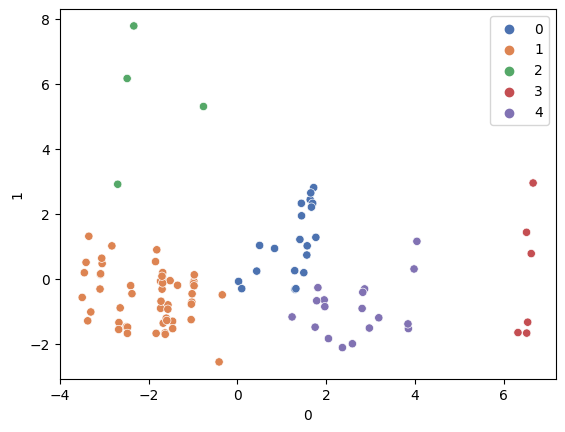

In [459]:
pca = wrap_model(PCA(n_components=2),
                 priority_columns=['zipcode', 'price'],
                 modifier=10).fit(sample)
pca_out = pd.DataFrame(pca.transform(sample))
sns.scatterplot(pca_out, x=0, y=1, hue=labels, palette='deep')

<Axes: xlabel='zipcode', ylabel='price'>

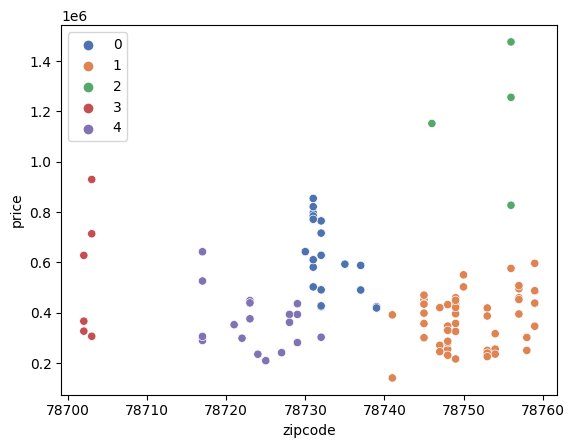

In [457]:
sns.scatterplot(sample, y=sample['price'], x=sample['zipcode'], hue=labels, palette='deep')

In [458]:
pd.options.display.float_format = '{:.2f}'.format
sample.groupby(labels).describe()

zipcode                                                            latitude  \
    count     mean  std      min      25%      50%      75%      max    count   
0   20.00 78732.85 2.85 78730.00 78731.00 78732.00 78732.75 78739.00    20.00   
1   52.00 78750.54 4.93 78741.00 78747.75 78749.00 78754.00 78759.00    52.00   
2    4.00 78753.50 5.00 78746.00 78753.50 78756.00 78756.00 78756.00     4.00   
3    6.00 78702.50 0.55 78702.00 78702.00 78702.50 78703.00 78703.00     6.00   
4   18.00 78723.94 4.81 78717.00 78721.25 78723.50 78728.00 78732.00    18.00   

         ... numOfStories      price                                 \
   mean  ...          75%  max count       mean       std       min   
0 30.32  ...         2.00 2.00 20.00  616533.26 147405.65 418714.42   
1 30.27  ...         2.00 3.00 52.00  370157.32 104666.19 140712.53   
2 30.31  ...         2.00 2.00  4.00 1178063.54 270137.45 827216.30   
3 30.28  ...         1.75 2.00  6.00  545136.30 252972.53 306274.28   
4 30.39  ...         2.00 2.00 18.00  362825.42 109310.05 209357.21   

                                               
         25%        50%        75%        max  
0  490710.41  601856.05  766549.77  854326.07  
1  277924.93  389220.91  442133.01  596190.00  
2 1071029.07 1204280.68 1311315.14 1476476.48  
3  336579.35  497162.32  692385.15  929707.79  
4  291757.35  357032.29  425198.26  642369.20  

[5 rows x 280 columns]

## Scoring based on multiple k-means

In [412]:
sample = data.sample(100).reset_index(drop=True)
target_house = sample.iloc[0]
target_index = start_house.name

In [448]:
score = pd.Series(0, index=range(len(sample)), name='score')
for clusters in [3,5,10,15]:
    kmeans = wrap_model(KMeans(n_clusters=clusters, n_init="auto"),
                        priority_columns=['zipcode', 'price'],
                        modifier=10).fit(sample)
    labels = kmeans.predict(sample)
    target_label = labels[target_index]
    score[labels == target_label] += 1
    
# NOTE: Top score contains the target house too atm

In [449]:
final = sample.join(score)
final.sort_values('score', ascending=False)

,zipcode,latitude,longitude,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,...,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,price,score
0,78749,30.20,-97.86,0,1,1,0,1,0,0,...,1,1.47,6.67,1460,16,3.00,4,2,439726.66,4
27,78749,30.21,-97.86,2,0,1,1,1,0,0,...,1,2.03,4.67,887,14,3.00,3,2,434033.24,4
94,78749,30.23,-97.87,2,1,1,1,1,0,0,...,1,3.57,6.00,1494,17,2.00,3,1,449352.06,4
18,78749,30.21,-97.88,2,1,1,1,1,0,0,...,1,0.97,9.00,1670,18,2.00,3,1,459564.61,4
51,78754,30.35,-97.61,2,1,1,1,1,0,1,...,2,2.03,5.00,1049,11,3.00,4,2,316603.19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,78722,30.29,-97.72,1,0,0,1,1,0,0,...,1,1.30,6.67,1156,15,1.00,2,1,298596.00,0
72,78732,30.36,-97.91,0,1,1,0,1,0,0,...,1,2.30,8.67,1533,17,3.00,4,2,302553.90,0
46,78717,30.49,-97.73,3,1,1,1,1,0,1,...,1,1.40,8.33,1913,16,4.00,4,1,642369.20,0
75,78729,30.45,-97.78,0,0,1,0,1,0,0,...,1,1.30,5.33,1369,12,4.00,5,2,435870.00,0


In [450]:
final.groupby('score').describe()

zipcode                                                              \
        count     mean   std      min      25%      50%      75%      max   
score                                                                       
0       43.00 78724.91 10.79 78702.00 78721.50 78729.00 78731.50 78746.00   
1       17.00 78755.06  6.23 78739.00 78756.00 78757.00 78758.00 78759.00   
2       34.00 78748.32  3.52 78741.00 78745.50 78748.00 78749.75 78756.00   
3        2.00 78749.50  6.36 78745.00 78747.25 78749.50 78751.75 78754.00   
4        4.00 78749.00  0.00 78749.00 78749.00 78749.00 78749.00 78749.00   

      latitude        ... numOfStories      price                      \
         count  mean  ...          75%  max count      mean       std   
score                 ...                                               
0        43.00 30.35  ...         2.00 2.00 43.00 521911.81 215522.30   
1        17.00 30.34  ...         2.00 2.00 17.00 547010.06 322731.67   
2        34.00 30.24  ...         2.00 3.00 34.00 346539.41 126588.77   
3         2.00 30.28  ...         1.75 2.00  2.00 393190.17 108310.35   
4         4.00 30.21  ...         2.00 2.00  4.00 445669.14  11215.39   

                                                          
            min       25%       50%       75%        max  
score                                                     
0     209357.21 357032.29 490202.25 642561.97 1152300.00  
1     250105.27 418714.42 452290.28 507570.20 1476476.48  
2     140712.53 251353.10 338358.35 414667.89  827216.30  
3     316603.19 354896.68 393190.17 431483.67  469777.16  
4     434033.24 438303.30 444539.36 451905.20  459564.61  

[5 rows x 280 columns]

In [451]:
final.groupby('score').mean()

,zipcode,latitude,longitude,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,price
score,,,,,,,,,,,,,,,,,,,,,
0,78724.91,30.35,-97.77,1.19,0.53,0.98,0.56,1.00,0.02,0.30,...,1.00,0.98,1.72,6.38,1286.12,15.05,2.57,3.16,1.40,521911.81
1,78755.06,30.34,-97.75,1.59,0.12,1.00,0.76,1.00,0.06,0.18,...,1.00,1.00,1.40,6.31,1278.35,15.88,2.47,3.41,1.41,547010.06
2,78748.32,30.24,-97.78,0.91,0.53,0.97,0.50,0.97,0.00,0.21,...,1.00,1.06,1.54,4.85,1223.29,14.41,2.25,3.32,1.35,346539.41
3,78749.50,30.28,-97.72,2.00,0.50,1.00,1.00,1.00,0.00,0.50,...,1.00,1.50,1.57,4.83,968.00,12.50,2.50,3.50,1.50,393190.17
4,78749.00,30.21,-97.87,1.50,0.75,1.00,0.75,1.00,0.00,0.00,...,1.00,1.00,2.01,6.58,1377.75,16.25,2.50,3.25,1.50,445669.14


In [454]:
pd.DataFrame(target_house).T

,zipcode,latitude,longitude,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,price
0,78749.00,30.20,-97.86,0.00,1.00,1.00,0.00,1.00,0.00,0.00,...,1.00,1.00,1.47,6.67,1460.00,16.00,3.00,4.00,2.00,439726.66
